In [39]:
#https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html
#could use to compute hessian and pass to optimizer?

In [40]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import sys
sys.path.append("../../")
import numpy as np

In [41]:
#General imports
import numpy as np

#Operator Imports
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2

from qiskit.circuit.library.standard_gates import CXGate
from qiskit.opflow import (StateFn, Zero, One, Plus, Minus, H,
                           DictStateFn, VectorStateFn, CircuitStateFn, OperatorStateFn)


import numpy as np
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki
from qiskit.circuit import Parameter
from qiskit import Aer
import random

In [42]:
# #from https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html
# # Instantiate the quantum state
# a = Parameter('a')
# b = Parameter('b')
# q = QuantumRegister(2)
# qc = QuantumCircuit(q)
# qc.h(q)
# qc.rz(a, q[0])
# qc.rx(b, q[0])

# # Instantiate the Hamiltonian observable
# H = (2 * X) + Z

# # Combine the Hamiltonian observable and the state
# op = ~StateFn(I) @ CircuitStateFn(primitive=qc, coeff=1.)

# # Print the operator corresponding to the expectation value
# # print(op)

# qc2 = QuantumCircuit(2)
# qc2.rx(a, 0)
# qc2.rx(b, 1)

# composedqc = qc.compose(qc2.inverse())
# # op = CircuitStateFn(primitive=qc2, coeff=1.)
# # print(op)

# op = CircuitStateFn(primitive=composedqc)
# print(op)

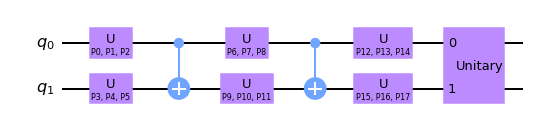

In [43]:
#first build basis template
from src.utils.custom_gates import RiSwapGate
from src.basis import CircuitTemplate
n_qubits = 2
basis = CircuitTemplate(n_qubits = n_qubits, base_gates = [CXGate()], preseed=False, use_polytopes=False, no_exterior_1q=0)
basis.build(2)
params = list(basis.circuit.parameters)
template_qc = basis.circuit

#define some ground truth cost function
from src.cost_function import BasicCost as Cost
cost = Cost()

#create target unitary and target state vector
from src.sampler import HaarSample, GateSample
from qiskit.quantum_info import Operator
from qiskit.circuit.library.standard_gates import CZGate, SwapGate, iSwapGate

#sampler = HaarSample(seed=0)
sampler = GateSample(gate=iSwapGate())
target_u = sampler._get_unitary()

target_qc = QuantumCircuit(n_qubits)
target_qc.append(Operator(target_u), range(n_qubits))
# target_vec = target_u @ np.array([1,0,0,0]) 
qc = template_qc.compose(target_qc.inverse())
qc.draw(output='mpl')

In [44]:
"""I think it's very likely there is an easier way to accomplish this, but I am coding this as I am still learning qiskit.opflow and having issues getting things to work
So I apologize to future self if this turns out to be an unnecessarily ugly solution :)"""

#convert into OperatorFn
#op = ~StateFn(target_vec) @ CircuitStateFn(primitive=qc, coeff=1.)

#construct expectation operator
#testing definition usiing template_circuit + adjoint(target_circuit)
#add stateFn for measurement

#op = ~CircuitStateFn(primitive=template_qc, coeff=1.) @  CircuitStateFn(primitive=target_qc)
op = CircuitStateFn(primitive=qc, is_measurement=True)
#op = ~StateFn(Z^I) @ CircuitStateFn(primitive=qc)
print(op)

CircuitMeasurement(
     ┌─────────────┐      ┌─────────────┐      ┌────────────────┐┌──────────┐
q_0: ┤ U(P0,P1,P2) ├──■───┤ U(P6,P7,P8) ├───■──┤ U(P12,P13,P14) ├┤0         ├
     ├─────────────┤┌─┴─┐┌┴─────────────┴┐┌─┴─┐├────────────────┤│  Unitary │
q_1: ┤ U(P3,P4,P5) ├┤ X ├┤ U(P9,P10,P11) ├┤ X ├┤ U(P15,P16,P17) ├┤1         ├
     └─────────────┘└───┘└───────────────┘└───┘└────────────────┘└──────────┘
)


In [59]:
basis.spanning_range = range(2,3)
from src.optimizer import TemplateOptimizer
optimizer = TemplateOptimizer(basis=basis, objective=cost)
optimizer_ret = optimizer.approximate_target_U(target_u)
previous_loss = optimizer_ret.loss_result
print(previous_loss)

8.940870266371803e-11


In [66]:
from weylchamber import c1c2c3


training_loss = []
coordinate_list = []

def optimize(starting_loss=None, starting_guess=None):
    training_loss.append(starting_loss)
    if starting_loss is None:
        starting_loss = 1/3 #so alpha = 1/8 which we found was an alright value
    if starting_guess is None:
        param_vals = basis.parameter_guess() #random starting guess
    else:
        param_vals = optimizer_ret.Xk
    its = 0
    alpha = 1/24*(starting_loss) #arbitary learning rate
    #
    
    c=0
    while True and its < 20:
        if its == 0:
            previous_loss = starting_loss
        its +=1

        alpha *= .9999 #mock simulated annealing 
        if its > 3 and previous_loss < 1/2:
            alpha *= .995
        if its > 3 and previous_loss < 1/4:
            alpha *= .99
        #set param values
        value_dict = {k:v for k,v in zip(params, param_vals)}

        #XXX
        measurement_qc = QuantumCircuit(n_qubits)
        #randomly modify measurement basis
        # for q in range(n_qubits):
        #     m_basis = random.choice(['x', 'y', 'z'])
        #     if m_basis == 'x' or m_basis == 'y' or m_basis == 'z':
        #         measurement_qc.h(q)
        #     if m_basis == 'y':
        #         measurement_qc.sdg(q)
        #     if m_basis == 'y' or m_basis == 'z':
        #         measurement_qc.h(q)
        # total_qc = measurement_qc.compose(qc)
        # op = CircuitStateFn(primitive=total_qc, is_measurement=True)

        measurement_string = ['xx', 'yx', 'zx', 'xy', 'yy', 'zy', 'xz', 'yz', 'zz']
        for m_s_el in measurement_string: #what if instead of random we do all of them
            #m_s_el = random.choice(measurement_string)
            for q in range(n_qubits):
                m_basis = m_s_el[q]
                if m_basis == 'x' or m_basis == 'y' or m_basis == 'z':
                    measurement_qc.h(q)
                if m_basis == 'y':
                    measurement_qc.sdg(q)
                if m_basis == 'y' or m_basis == 'z':
                    measurement_qc.h(q)
            total_qc = measurement_qc.compose(qc)
            op = CircuitStateFn(primitive=total_qc, is_measurement=True)
            #calculate gradient
            grad = Gradient().convert(operator = op, params = params)
            grad_result = grad.assign_parameters(value_dict).eval()

            #alt gradient method
            #state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)
            #state_grad_result = state_grad.assign_parameters(value_dict).eval()

            #update param values
            #there are lots of ways I can imagine doing this,
            #for starters, lets just sample the expectation vectorstatefn and only update that one
            # c += 1
            # c %=4

            bit_convert = ['00', '01', '10','11']
            m = CircuitStateFn(measurement_qc)
            sample = list(m.eval().sample())[0]
            
            #need to determine if we need to move up or down based on current value
            #right now just says if >.5 go up, but its possible we are already above the value
            #say expectation value is .55 and current anstaz has .75 then should want to go down
            for c in range(2**n_qubits):
                if np.array(abs(m.to_matrix()) - abs(op.assign_parameters(value_dict).eval().to_matrix()))[0][c] >= 0:
                #[abs(el)>=.5 for el in m.to_matrix()][c]: #bit_convert[c] == sample:
                    param_vals = [el + alpha * gradient_el[c] for el, gradient_el in zip(param_vals, grad_result)]
                else:
                    param_vals = [el - alpha * gradient_el[c] for el, gradient_el in zip(param_vals, grad_result)]

        #param_vals = [el - alpha * gradient_el for el, gradient_el in zip(param_vals, grad_result)]
        
        #for safety
        param_vals = np.real(param_vals)

        #evaluate ground truth
        current_template = basis.eval(Xk=param_vals)
        gt_cost = cost.unitary_fidelity(current_u= current_template, target_u=target_u)
        print(gt_cost, alpha)
        training_loss.append(gt_cost)
        previous_loss = gt_cost
        coordinate_list.append(c1c2c3(current_template))

        #print(op.assign_parameters(value_dict).eval())
    return value_dict
#vd = optimize(starting_loss=previous_loss, starting_guess=optimizer_ret.Xk)
vd = optimize()

import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.xlabel("training iters")
plt.ylabel("unitary fidelity")

0.739887653571191 0.013887499999999999
0.7377573034746026 0.01388611125
0.7351948868261645 0.013884722638875
0.7322526154433768 0.013883334166611113
0.7289874889852194 0.013881945833194452
0.7245767511955286 0.013880557638611133


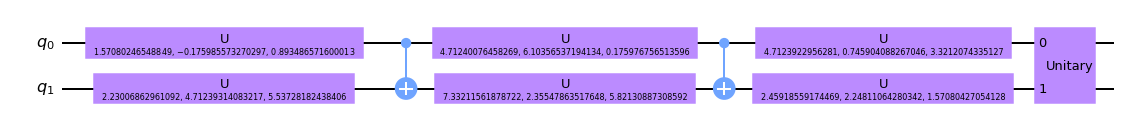

In [61]:
trained_qc = qc.assign_parameters(vd)
trained_qc.draw(output='mpl')

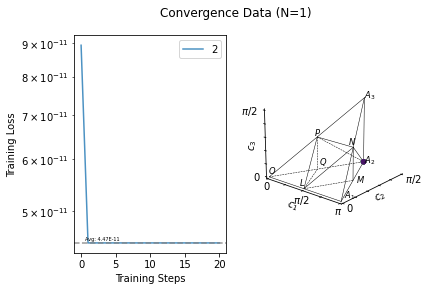

In [62]:
from src.utils.visualize import optimizer_training_plot
#if successful, should be Identity, because we have created template to match dagger of target
optimizer_training_plot([[-1,2] + training_loss], [coordinate_list]);

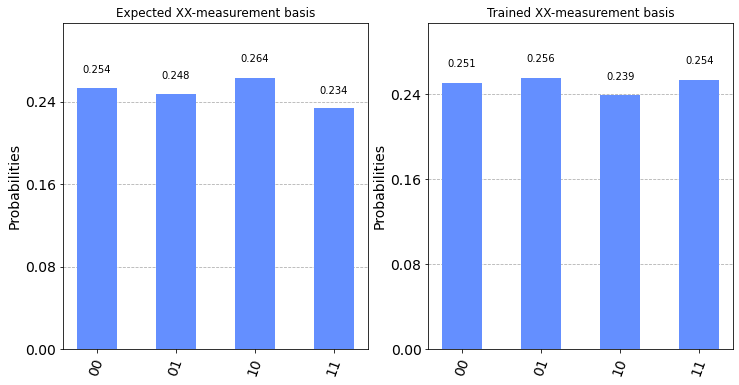

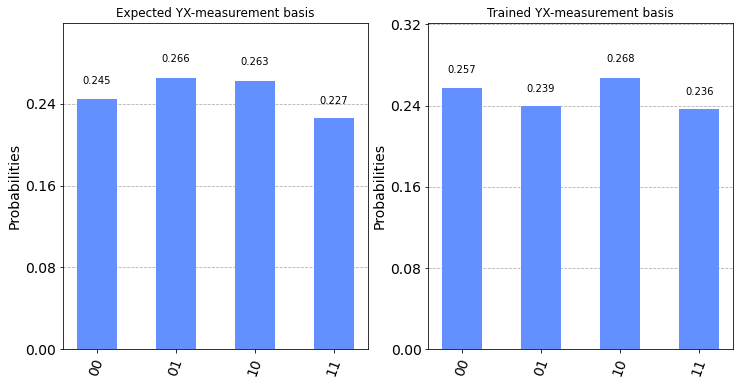

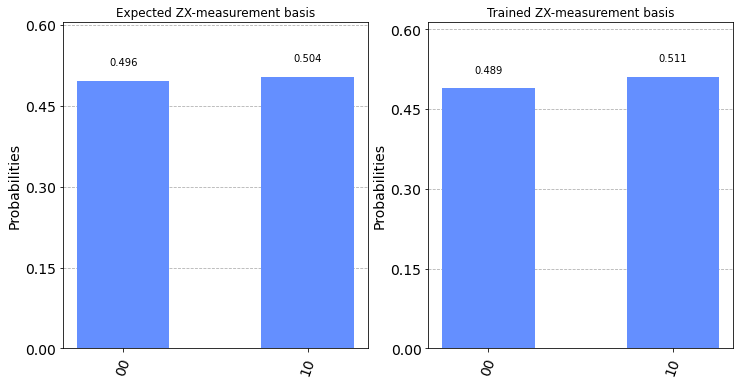

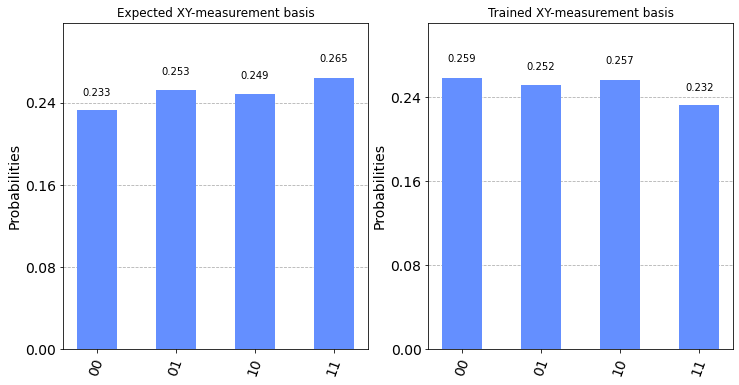

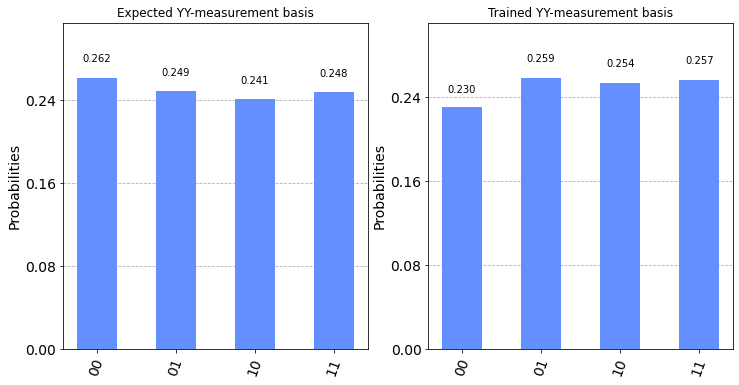

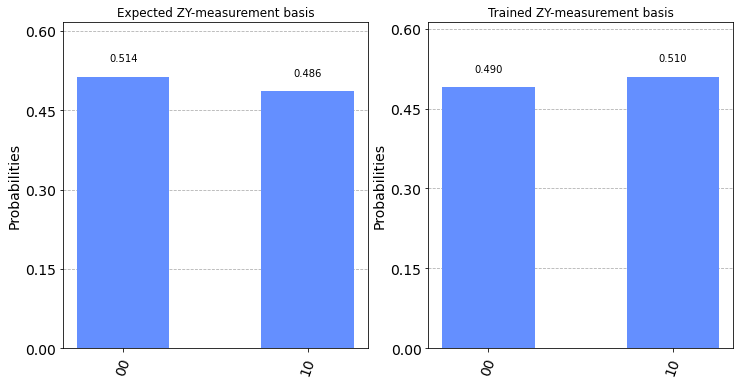

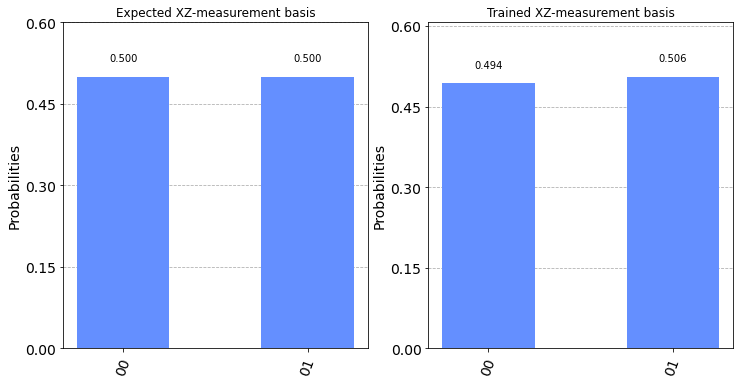

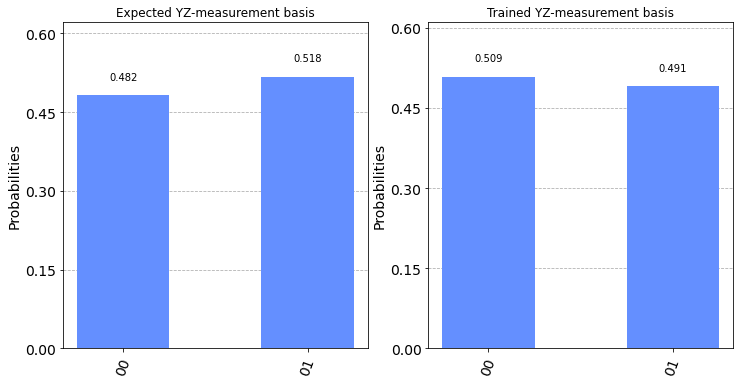

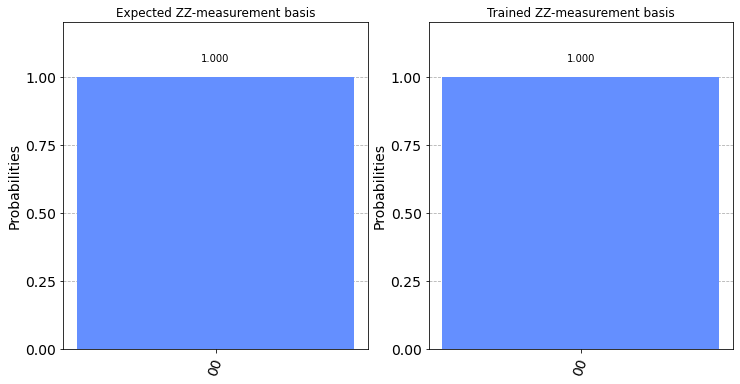

In [63]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
simulator = Aer.get_backend('aer_simulator')


# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(trained_qc, simulator)

#add measurement
measurement_string = ['xx', 'yx', 'zx', 'xy', 'yy', 'zy', 'xz', 'yz', 'zz']
for m_s_el in measurement_string:
    measurement_qc = QuantumCircuit(n_qubits)
    for q in range(n_qubits):
        m_basis = m_s_el[q]
        if m_basis == 'x' or m_basis == 'y' or m_basis == 'z':
            measurement_qc.h(q)
        if m_basis == 'y':
            measurement_qc.sdg(q)
        if m_basis == 'y' or m_basis == 'z':
            measurement_qc.h(q)
    total_qc = circ.compose(measurement_qc)
    measurement_qc.measure_all()
    total_qc.measure_all()
    
    # Run and get counts
    expected_result = simulator.run(measurement_qc).result()
    actual_result = simulator.run(total_qc).result()
    e_counts = expected_result.get_counts(measurement_qc)
    a_counts = actual_result.get_counts(total_qc)

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    plot_histogram(e_counts, ax=ax1,title=f'Expected {m_s_el.upper()}-measurement basis')
    ax2 = fig.add_subplot(122)
    plot_histogram(a_counts, ax=ax2,title=f'Trained {m_s_el.upper()}-measurement basis')
    fig.show()

In [64]:
# # Besides the method to compute the circuit gradients resp. QFI, a regularization method can be chosen:
# # `ridge` or `lasso` with automatic parameter search or `perturb_diag_elements` or `perturb_diag`
# # which perturb the diagonal elements of the QFI.
# nat_grad = NaturalGradient(grad_method='lin_comb', qfi_method='lin_comb_full', regularization='ridge').convert(
#                            operator=op, params=params)

# # Assign the parameters and evaluate the gradient
# nat_grad_result = nat_grad.assign_parameters(value_dict).eval()
# print('Natural gradient computed with linear combination of unitaries', nat_grad_result)

In [65]:
# # Get the operator object representing the Hessian
# state_hess = Hessian(hess_method='param_shift').convert(operator=op, params=params)
# # Assign the parameters and evaluate the Hessian
# hessian_result = state_hess.assign_parameters(value_dict).eval()
# print('Hessian computed using the parameter shift method\n', (np.array(hessian_result)))

# # Get the operator object representing the Hessian
# state_hess = Hessian(hess_method='lin_comb').convert(operator=op, params=params)
# # Assign the parameters and evaluate the Hessian
# hessian_result = state_hess.assign_parameters(value_dict).eval()
# print('Hessian computed using the linear combination of unitaries method\n', (np.array(hessian_result)))

# # Get the operator object representing the Hessian using finite difference
# state_hess = Hessian(hess_method='fin_diff').convert(operator=op, params=params)
# # Assign the parameters and evaluate the Hessian
# hessian_result = state_hess.assign_parameters(value_dict).eval()
# print('Hessian computed with finite difference\n', (np.array(hessian_result)))